In [1]:
import numpy as np
import pandas as pd
import math
import random

import requests
import json
import csv
from multiprocessing import Pool

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings; warnings.filterwarnings(action='once')

large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}

plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

## Part 1

### Readin Loans

In [2]:
sample = pd.read_csv("/Users/ling/Desktop/Interview/Better/loans.csv", header=None)
sample.columns = ["loan", "address", "created_ts", "funded_ts"]

In [3]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5143 entries, 0 to 5142
Data columns (total 4 columns):
loan          5143 non-null float64
address       5143 non-null object
created_ts    5143 non-null object
funded_ts     1055 non-null object
dtypes: float64(1), object(3)
memory usage: 160.8+ KB


In [4]:
sample.head(2)

,loan,address,created_ts,funded_ts
0,568705.0,"22226 Brookpine, Mission Viejo CA 92692",2016-12-20T07:16:04.778800+00:00,NaN
1,413165.0,"124 Vignolia Court, Roseville CA 95747",2016-10-11T20:35:19.951835+00:00,2016-11-07T00:00:00+00:00


In [5]:
sample.describe()

,loan
count,5.143000e+03
mean,3.823894e+05
std,1.271108e+06
min,9.000000e+00
25%,2.166565e+05
50%,3.179370e+05
75%,4.216590e+05
max,5.776249e+07


### Data Cleaning

In [6]:
upper = sample['loan'].quantile(0.975); print(upper)
lower = sample['loan'].quantile(0.025); print(lower)

883114.3
82069.85


In [7]:
df = sample[(sample['loan']>=lower) & (sample['loan']<=upper)].copy()

In [8]:
df['zip'] = df['address'].apply(lambda x: x.split(" ")[-1])
df['state'] = df['address'].apply(lambda x: x.split(" ")[-2])

In [9]:
df.head(2)

,loan,address,created_ts,funded_ts,zip,state
0,568705.0,"22226 Brookpine, Mission Viejo CA 92692",2016-12-20T07:16:04.778800+00:00,NaN,92692,CA
1,413165.0,"124 Vignolia Court, Roseville CA 95747",2016-10-11T20:35:19.951835+00:00,2016-11-07T00:00:00+00:00,95747,CA


In [10]:
df.describe()

,loan
count,4885.000000
mean,337882.609007
std,154681.855697
min,82127.000000
25%,222139.000000
50%,317937.000000
75%,417000.000000
max,883099.000000


In [11]:
df.groupby('zip').size().reset_index(name='cnt').sort_values('cnt', ascending=False).head(10)

,zip,cnt
1949,98115,20
1295,92127,18
1900,98012,17
1955,98122,16
1963,98155,16
1940,98103,16
1668,95123,15
1562,94536,15
1568,94546,15
1584,94568,15


In [12]:
sorted = df.groupby('state').agg({'loan': [len, np.mean]}).reset_index()
sorted.columns=sorted.columns.get_level_values(0)
sorted.columns=['state','loans', 'avg loans']
sorted.sort_values('loans', ascending=False)

,state,loans,avg loans
1,CA,2313.0,393240.028534
15,WA,658.0,341785.056231
10,NJ,307.0,319993.859935
13,PA,279.0,227678.480287
9,NC,245.0,248718.510204
6,GA,220.0,254174.318182
7,IL,213.0,266901.450704
12,OR,149.0,281594.067114
5,FL,145.0,233037.731034
0,AZ,122.0,245116.549180


Text(0.5, 1.0, 'Box Plot of Loan Amounts by State')

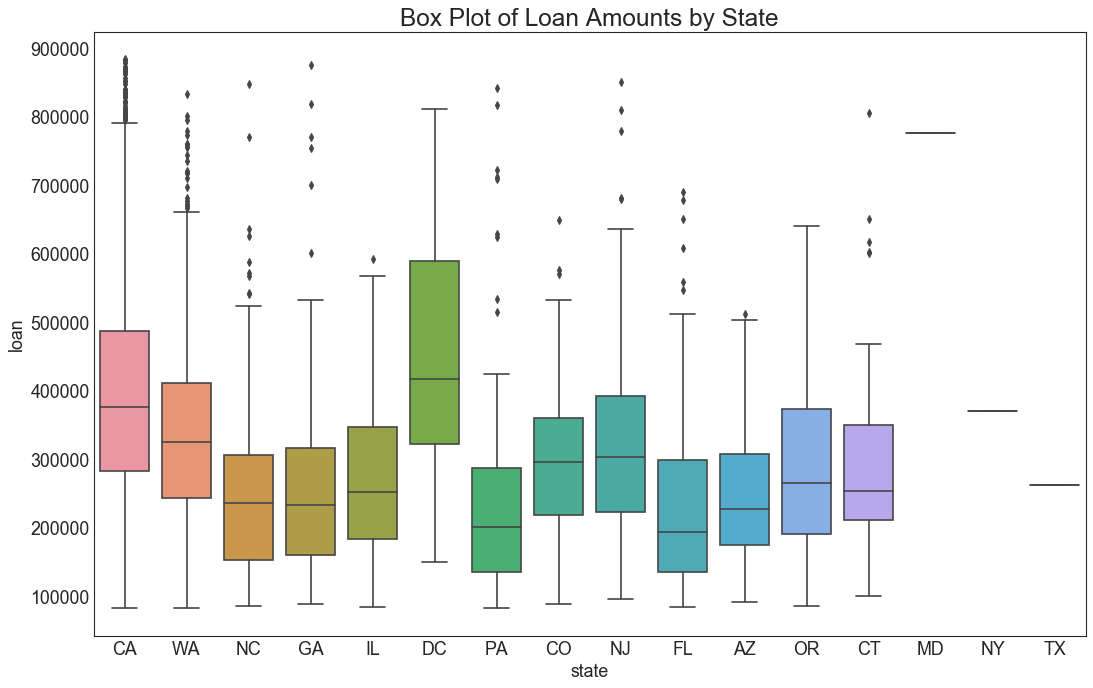

In [13]:
plt.figure(figsize=(16,10), dpi= 80)
sns.boxplot(x='state', y='loan', data=df, notch=False)
plt.title('Box Plot of Loan Amounts by State', fontsize=22)

In [14]:
len(df)

4885

In [15]:
df.head(2)

,loan,address,created_ts,funded_ts,zip,state
0,568705.0,"22226 Brookpine, Mission Viejo CA 92692",2016-12-20T07:16:04.778800+00:00,NaN,92692,CA
1,413165.0,"124 Vignolia Court, Roseville CA 95747",2016-10-11T20:35:19.951835+00:00,2016-11-07T00:00:00+00:00,95747,CA


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4885 entries, 0 to 5142
Data columns (total 6 columns):
loan          4885 non-null float64
address       4885 non-null object
created_ts    4885 non-null object
funded_ts     1049 non-null object
zip           4885 non-null object
state         4885 non-null object
dtypes: float64(1), object(5)
memory usage: 427.1+ KB


In [17]:
df['created_dt'] = df['created_ts'].apply(lambda x: datetime.strptime(x.split("T")[0], '%Y-%m-%d').date())

In [18]:
df['funded_dt'] = df['funded_ts'].apply(lambda x: None if str(x).lower()=='nan' else datetime.strptime(str(x).split("T")[0], '%Y-%m-%d').date())

In [19]:
df['duration'] = (df['funded_dt']-df['created_dt']).apply(lambda x: max(0,x.days))

In [20]:
df['convert'] = df['funded_dt'].apply(lambda x: 0 if x is None  else 1)

In [21]:
df['convert'].describe()

count    4885.000000
mean        0.214739
std         0.410683
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: convert, dtype: float64

In [22]:
df[df['duration']>0]['duration'].describe()

count    1046.000000
mean       49.512428
std        22.958072
min        16.000000
25%        36.000000
50%        45.000000
75%        58.000000
max       430.000000
Name: duration, dtype: float64

### Aggregate Data

In [23]:
date_format='%Y-%m'
df['create_year_mon']=df['created_dt'].apply(lambda x: x.strftime(date_format))

In [24]:
df['duration_mon']=df['duration'].apply(lambda x: x//30)

In [25]:
df2=df.groupby(['create_year_mon']).size().reset_index(name='loads')

In [26]:
df3=df.groupby(['create_year_mon','duration_mon'])['convert'].sum().reset_index(name='convert')

In [27]:
df['create_year_mon'].value_counts()

2017-01    492
2017-08    490
2017-07    459
2017-09    437
2017-06    401
2017-10    394
2017-11    335
2016-12    299
2017-02    244
2016-11    242
2017-03    206
2017-05    198
2016-10    169
2017-04    162
2017-12    132
2016-09    119
2016-05     45
2016-04     31
2016-08     15
2016-03      9
2016-07      3
2016-06      2
2016-02      1
Name: create_year_mon, dtype: int64

In [28]:
df['duration_mon'].value_counts()

0     3954
1      692
2      200
3       32
6        3
4        3
14       1
Name: duration_mon, dtype: int64

In [29]:
mons1=df['create_year_mon'].value_counts().index
mons2=range(7)

In [30]:
from itertools import product

In [31]:
l=[]
for mon1, mon2 in product(mons1, mons2):
    l.append([mon1, mon2])

In [32]:
driver=pd.DataFrame(l, columns=['create_year_mon','duration_mon']).sort_values(['create_year_mon','duration_mon']).reset_index(drop=True)

In [33]:
driver = pd.merge(driver, df2, on=['create_year_mon'], how='left')

In [34]:
driver = pd.merge(driver, df3, on=['create_year_mon','duration_mon'], how='left')
driver = driver.fillna(0)

In [35]:
driver['conversion_rate']=driver['convert']/driver['loads']

In [36]:
result = driver.pivot_table(index='create_year_mon', columns='duration_mon', values='conversion_rate')

In [37]:
plot_df = df['create_year_mon'].value_counts().reset_index(name='number_of_loans')
plot_df.columns =['create_year_mon','number_of_loans']
plot_df=plot_df.sort_values(['create_year_mon'])

In [38]:
plot_df.describe()

,number_of_loans
count,23.000000
mean,212.391304
std,172.334437
min,1.000000
25%,38.000000
50%,198.000000
75%,364.500000
max,492.000000


Text(0.5, 1.0, 'Number of Loans by Creation Month')

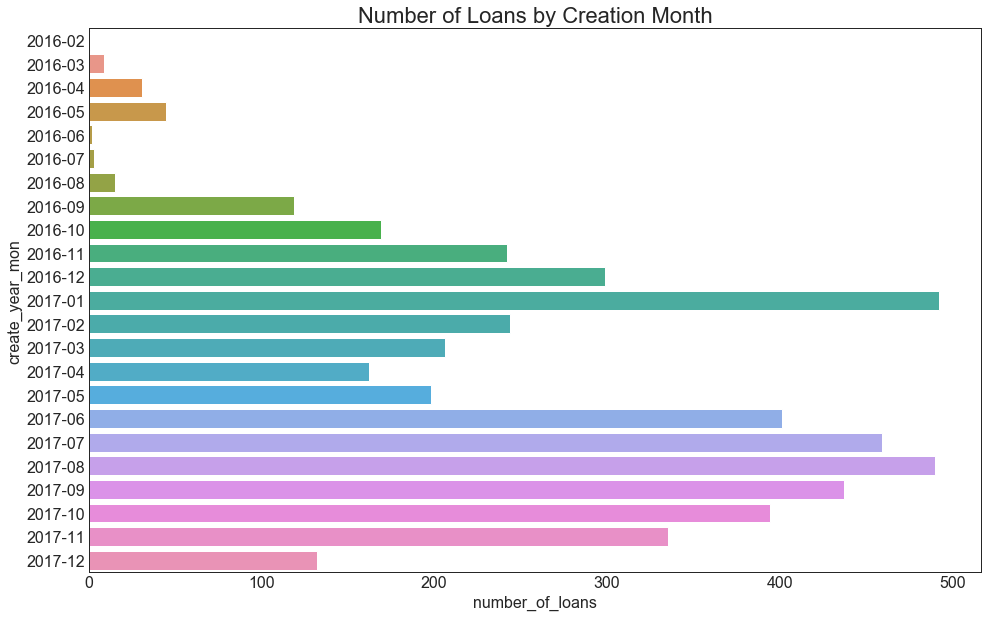

In [39]:
plt.figure(figsize=(16,10))
sns.barplot(y='create_year_mon', x='number_of_loans',data=plot_df)
plt.title('Number of Loans by Creation Month', fontsize=22)

Text(0.5, 1.0, 'Conversion Rates by Creation Month and Duration')

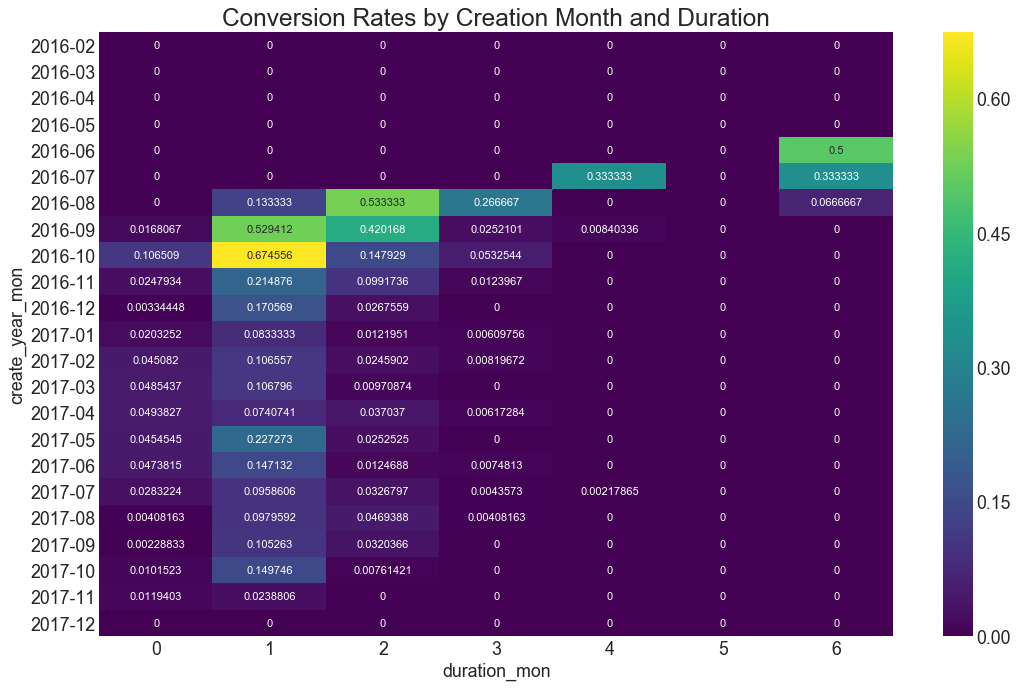

In [40]:
plt.figure(figsize=(16,10), dpi= 80)
sns.heatmap(result, annot=True, fmt="g", cmap='viridis')
plt.title('Conversion Rates by Creation Month and Duration', fontsize=22)

## Part 2

### Fetch and readin county code

In [41]:
def parse_one_address(address):
    url = 'https://geomap.ffiec.gov/FFIECGeocMap/GeocodeMap1.aspx/GetGeocodeData'
    headers = {'content-type':'application/json'}
    data = {'sSingleLine': address, 'iCensusYear': "2018"}  
    r = requests.post(url, data = json.dumps(data), headers=headers)
    d = r.json()['d']
    return ([address, d['sMatchAddr'],d['sStateCode'],d['sStateAbbr'],d['sCountyCode'],d['sCountyName']])

def main(rowid):
    print(rowid)
    try:
        res = parse_one_address(sample.loc[rowid, 'address'])
        with open("output.csv", 'a') as csvFile:
            writer = csv.writer(csvFile)
            writer.writerow(res)
        csvFile.close()
    except Exception as e:
        print(e)

# pool = Pool(5)
# pool.map(main, [i for i in range(len(sample))]) 

In [42]:
sample2 = pd.read_csv("/Users/ling/Desktop/Interview/Better/output.csv", header=None)
sample2.columns = ['address','MatchAddr','StateCode','StateAbbr','CountyCode','CountyName']

In [43]:
sample2.head(2)

,address,MatchAddr,StateCode,StateAbbr,CountyCode,CountyName
0,"2214 Streatley Ln, Matthews NC 28105","2214 STREATLEY LN, MATTHEWS, NC, 28105",37.0,NC,119.0,MECKLENBURG COUNTY ...
1,"7528 Franklin Ave, Los Angeles CA 90046","7528 FRANKLIN AVE, LOS ANGELES, CA, 90046",6.0,CA,37.0,LOS ANGELES COUNTY ...


In [44]:
sample2['StateCode']=sample2['StateCode'].fillna(0).astype(int).astype(str)
sample2['CountyCode']=sample2['CountyCode'].fillna(0).astype(int).astype(str)

In [45]:
sample2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5143 entries, 0 to 5142
Data columns (total 6 columns):
address       5143 non-null object
MatchAddr     4772 non-null object
StateCode     5143 non-null object
StateAbbr     4772 non-null object
CountyCode    5143 non-null object
CountyName    4772 non-null object
dtypes: object(6)
memory usage: 241.2+ KB


In [46]:
sample2.head(2)

,address,MatchAddr,StateCode,StateAbbr,CountyCode,CountyName
0,"2214 Streatley Ln, Matthews NC 28105","2214 STREATLEY LN, MATTHEWS, NC, 28105",37,NC,119,MECKLENBURG COUNTY ...
1,"7528 Franklin Ave, Los Angeles CA 90046","7528 FRANKLIN AVE, LOS ANGELES, CA, 90046",6,CA,37,LOS ANGELES COUNTY ...


In [47]:
4772/5143

0.9278631149134746

In [48]:
county = pd.merge(df, sample2, on='address', how='left' )

In [49]:
sum(county['state']==county['StateAbbr'])

4533

### Readin County Limits

In [50]:
sample3 = pd.ExcelFile("/Users/ling/Desktop/Interview/Better/FullCountyLoanLimitList2017.xlsx")
limits = sample3.parse("GSE Limits", header=1)

In [51]:
limits.head()

,FIPS State Code,FIPS County Code,County Name,State,CBSA Number,One-Unit Limit,Two-Unit Limit,Three-Unit Limit,Four-Unit Limit
0,1,1,AUTAUGA,AL,33860.0,424100,543000,656350,815650
1,1,3,BALDWIN,AL,19300.0,424100,543000,656350,815650
2,1,5,BARBOUR,AL,NaN,424100,543000,656350,815650
3,1,7,BIBB,AL,13820.0,424100,543000,656350,815650
4,1,9,BLOUNT,AL,13820.0,424100,543000,656350,815650


In [52]:
limits['FIPS State Code']=limits['FIPS State Code'].astype(str)
limits['FIPS County Code']=limits['FIPS County Code'].astype(str)
limits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3234 entries, 0 to 3233
Data columns (total 9 columns):
FIPS State Code     3234 non-null object
FIPS County Code    3234 non-null object
County Name         3234 non-null object
State               3234 non-null object
CBSA Number         1882 non-null float64
One-Unit Limit      3234 non-null int64
Two-Unit Limit      3234 non-null int64
Three-Unit Limit    3234 non-null int64
Four-Unit Limit     3234 non-null int64
dtypes: float64(1), int64(4), object(4)
memory usage: 227.5+ KB


In [53]:
county.head(2)

,loan,address,created_ts,funded_ts,zip,state,created_dt,funded_dt,duration,convert,create_year_mon,duration_mon,MatchAddr,StateCode,StateAbbr,CountyCode,CountyName
0,568705.0,"22226 Brookpine, Mission Viejo CA 92692",2016-12-20T07:16:04.778800+00:00,NaN,92692,CA,2016-12-20,None,0,0,2016-12,0,"22226 BROOKPINE, MISSION VIEJO, CA, 92692",6,CA,59,ORANGE COUNTY ...
1,413165.0,"124 Vignolia Court, Roseville CA 95747",2016-10-11T20:35:19.951835+00:00,2016-11-07T00:00:00+00:00,95747,CA,2016-10-11,2016-11-07,27,1,2016-10,0,"124 VIGNOLIA CT, ROSEVILLE, CA, 95747",6,CA,61,PLACER COUNTY ...


In [54]:
all=pd.merge(county, limits, left_on=['StateCode','CountyCode'], right_on=['FIPS State Code','FIPS County Code'], how='left')

In [55]:
all.head(2)

,loan,address,created_ts,funded_ts,zip,state,created_dt,funded_dt,duration,convert,...,CountyName,FIPS State Code,FIPS County Code,County Name,State,CBSA Number,One-Unit Limit,Two-Unit Limit,Three-Unit Limit,Four-Unit Limit
0,568705.0,"22226 Brookpine, Mission Viejo CA 92692",2016-12-20T07:16:04.778800+00:00,NaN,92692,CA,2016-12-20,None,0,0,...,ORANGE COUNTY ...,6,59,ORANGE,CA,31080.0,636150.0,814500.0,984525.0,1223475.0
1,413165.0,"124 Vignolia Court, Roseville CA 95747",2016-10-11T20:35:19.951835+00:00,2016-11-07T00:00:00+00:00,95747,CA,2016-10-11,2016-11-07,27,1,...,PLACER COUNTY ...,6,61,PLACER,CA,40900.0,488750.0,625700.0,756300.0,939900.0


In [56]:
all.describe()

,loan,duration,convert,duration_mon,CBSA Number,One-Unit Limit,Two-Unit Limit,Three-Unit Limit,Four-Unit Limit
count,4885.000000,4885.000000,4885.000000,4885.000000,4508.000000,4534.000000,4534.000000,4534.000000,4.534000e+03
mean,337882.609007,10.601842,0.214739,0.252201,34837.491127,536459.395677,686838.029334,830212.902514,1.031724e+06
std,154681.855697,22.921235,0.410683,0.610663,9770.082867,97682.575475,125061.138205,151165.286668,1.878599e+05
min,82127.000000,0.000000,0.000000,0.000000,10140.000000,424100.000000,543000.000000,656350.000000,8.156500e+05
25%,222139.000000,0.000000,0.000000,0.000000,31080.000000,424100.000000,543000.000000,656350.000000,8.156500e+05
50%,317937.000000,0.000000,0.000000,0.000000,38900.000000,592250.000000,758200.000000,916450.000000,1.138950e+06
75%,417000.000000,0.000000,0.000000,0.000000,41860.000000,636150.000000,814500.000000,984525.000000,1.223475e+06
max,883099.000000,430.000000,1.000000,14.000000,49740.000000,636150.000000,814500.000000,984525.000000,1.223475e+06


In [57]:
all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4885 entries, 0 to 4884
Data columns (total 26 columns):
loan                4885 non-null float64
address             4885 non-null object
created_ts          4885 non-null object
funded_ts           1049 non-null object
zip                 4885 non-null object
state               4885 non-null object
created_dt          4885 non-null object
funded_dt           1049 non-null object
duration            4885 non-null int64
convert             4885 non-null int64
create_year_mon     4885 non-null object
duration_mon        4885 non-null int64
MatchAddr           4534 non-null object
StateCode           4885 non-null object
StateAbbr           4534 non-null object
CountyCode          4885 non-null object
CountyName          4534 non-null object
FIPS State Code     4534 non-null object
FIPS County Code    4534 non-null object
County Name         4534 non-null object
State               4534 non-null object
CBSA Number         4508 non-null 

In [58]:
all['jumbo'] = all['loan']>=all['One-Unit Limit']

In [59]:
pd.concat([all['jumbo'].value_counts(), all['jumbo'].value_counts()/len(all)], axis=1)

,jumbo,jumbo
False,4606,0.942886
True,279,0.057114


In [60]:
all['jumbo'].value_counts()

False    4606
True      279
Name: jumbo, dtype: int64

In [61]:
all['jumbo'].value_counts()/len(all)

False    0.942886
True     0.057114
Name: jumbo, dtype: float64

In [62]:
all.groupby(['jumbo'])['convert'].describe()

,count,mean,std,min,25%,50%,75%,max
jumbo,,,,,,,,
False,4606.0,0.224490,0.417291,0.0,0.0,0.0,0.0,1.0
True,279.0,0.053763,0.225956,0.0,0.0,0.0,0.0,1.0


In [63]:
all.groupby(['jumbo'])['convert'].sum()

jumbo
False    1034
True       15
Name: convert, dtype: int64

In [64]:
driver = pd.DataFrame([all['jumbo'].value_counts()]*7)

In [65]:
driver['duration_mon']=range(7)

In [66]:
driver

,False,True,duration_mon
jumbo,4606,279,0
jumbo,4606,279,1
jumbo,4606,279,2
jumbo,4606,279,3
jumbo,4606,279,4
jumbo,4606,279,5
jumbo,4606,279,6


In [67]:
plot_df= all.groupby(['duration_mon', 'jumbo'])['convert'].sum().reset_index(name='convert')
plot_df2 = plot_df.pivot(index='duration_mon', columns='jumbo', values='convert')

In [68]:
plot_df3=pd.merge(driver, plot_df2, on=['duration_mon'], how='left')
plot_df3['False_conversion_rate']=plot_df3['False_y']/plot_df3['False_x']
plot_df3['True_conversion_rate']=plot_df3['True_y']/plot_df3['True_x']

In [69]:
plot_df3.columns=['conforming', 'jumbo', 'duration_mon', 'conforming_convert', 'jumbo_convert', 'conforming_conversion_rate','jumbo_conversion_rate']

In [70]:
plot_df3

,conforming,jumbo,duration_mon,conforming_convert,jumbo_convert,conforming_conversion_rate,jumbo_conversion_rate
0,4606,279,0,118.0,0.0,0.025619,0.000000
1,4606,279,1,683.0,9.0,0.148285,0.032258
2,4606,279,2,195.0,5.0,0.042336,0.017921
3,4606,279,3,31.0,1.0,0.006730,0.003584
4,4606,279,4,3.0,NaN,0.000651,NaN
5,4606,279,5,NaN,NaN,NaN,NaN
6,4606,279,6,3.0,NaN,0.000651,NaN


In [71]:
all['loan_range']=pd.cut(all['loan'], 10)

In [72]:
all.groupby('loan_range')['loan_range'].size().reset_index(name='cnt').sort_values('loan_range',ascending=True)

,loan_range,cnt
0,"(81326.028, 162224.2]",569
1,"(162224.2, 242321.4]",901
2,"(242321.4, 322418.6]",1037
3,"(322418.6, 402515.8]",951
4,"(402515.8, 482613.0]",610
5,"(482613.0, 562710.2]",327
6,"(562710.2, 642807.4]",302
7,"(642807.4, 722904.6]",87
8,"(722904.6, 803001.8]",55
9,"(803001.8, 883099.0]",46


In [73]:
grp_mean = all.groupby(['loan_range', 'jumbo']).agg({'convert': [len, np.sum, np.mean]}).reset_index()
grp_mean_pivot = grp_mean.pivot(index='loan_range', columns='jumbo')
grp_mean_pivot.columns = grp_mean_pivot.columns.get_level_values(0)
grp_mean_pivot.columns=['conforming loans', 'jumbo loans', 'conforming convert', 'jumbo convert','conforming conversion rate', 'jumbo conversion rate']
grp_mean_pivot

,conforming loans,jumbo loans,conforming convert,jumbo convert,conforming conversion rate,jumbo conversion rate
loan_range,,,,,,
"(81326.028, 162224.2]",569.0,NaN,61.0,NaN,0.107206,NaN
"(162224.2, 242321.4]",901.0,NaN,147.0,NaN,0.163152,NaN
"(242321.4, 322418.6]",1037.0,NaN,267.0,NaN,0.257473,NaN
"(322418.6, 402515.8]",951.0,NaN,291.0,NaN,0.305994,NaN
"(402515.8, 482613.0]",580.0,30.0,152.0,2.0,0.262069,0.066667
"(482613.0, 562710.2]",294.0,33.0,59.0,2.0,0.200680,0.060606
"(562710.2, 642807.4]",256.0,46.0,57.0,3.0,0.222656,0.065217
"(642807.4, 722904.6]",8.0,79.0,0.0,5.0,0.000000,0.063291
"(722904.6, 803001.8]",6.0,49.0,0.0,1.0,0.000000,0.020408


In [74]:
grp_mean2 = all.groupby(['state','FIPS County Code', 'jumbo']).agg({'convert': [len, np.sum, np.mean]}).reset_index()
grp_mean2.columns = grp_mean2.columns.get_level_values(0)
grp_mean2.columns=['state', 'FIPS County Code', 'jumbo', 'loans', 'convert', 'conversion rate']

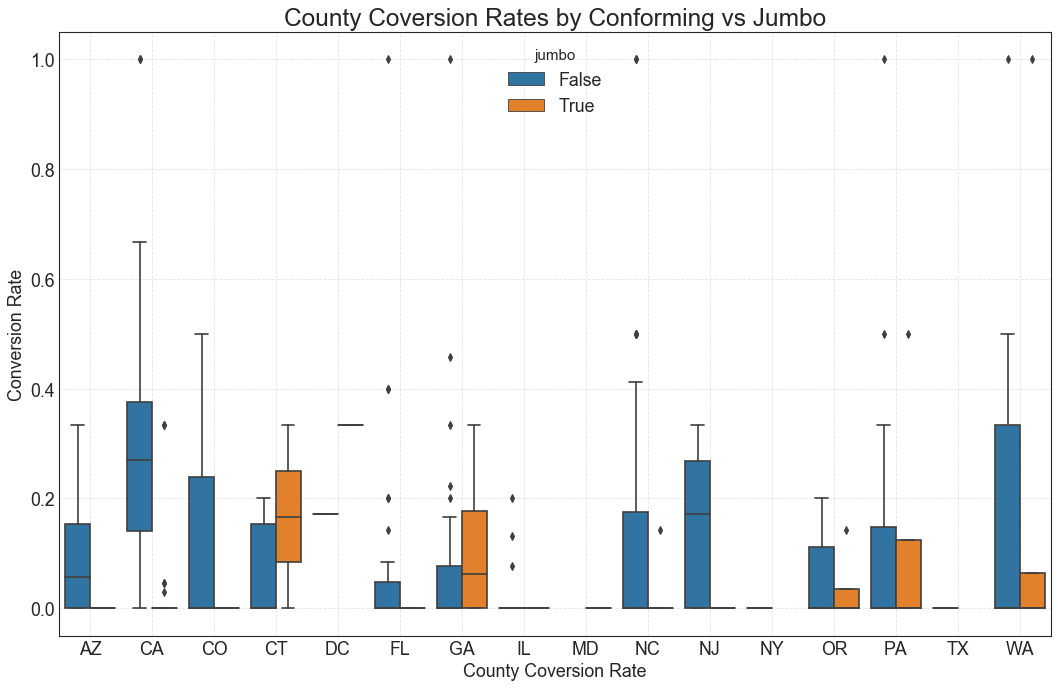

In [75]:
plt.figure(figsize=(16,10), dpi= 80)
sns.boxplot(x='state', y='conversion rate', hue='jumbo', data=grp_mean2, notch=False)

# Decorations
plt.gca().set(xlabel='County Coversion Rate', ylabel='Conversion Rate')
plt.title('County Coversion Rates by Conforming vs Jumbo', fontsize=22)
plt.grid(linestyle='--', alpha=0.5)
plt.show()

In [76]:
grp_mean3 = all.groupby(['state', 'jumbo']).agg({'convert': [len, np.sum, np.mean]}).reset_index()
grp_mean_pivot3 = grp_mean3.pivot(index='state', columns='jumbo')
grp_mean_pivot3.columns = grp_mean_pivot3.columns.get_level_values(0)
grp_mean_pivot3.columns=['conforming loans', 'jumbo loans', 'conforming convert', 'jumbo convert','conforming conversion rate', 'jumbo conversion rate']
grp_mean_pivot3.sort_values('conforming loans', ascending=False)

,conforming loans,jumbo loans,conforming convert,jumbo convert,conforming conversion rate,jumbo conversion rate
state,,,,,,
CA,2153.0,160.0,595.0,5.0,0.276359,0.031250
WA,623.0,35.0,177.0,3.0,0.284109,0.085714
NJ,300.0,7.0,64.0,0.0,0.213333,0.000000
PA,273.0,6.0,30.0,1.0,0.109890,0.166667
NC,232.0,13.0,43.0,1.0,0.185345,0.076923
GA,207.0,13.0,31.0,2.0,0.149758,0.153846
IL,205.0,8.0,19.0,0.0,0.092683,0.000000
OR,139.0,10.0,21.0,1.0,0.151079,0.100000
FL,136.0,9.0,13.0,0.0,0.095588,0.000000
